Starting training...

===== Channel Gains =====
Pair 1:
h1: 2.5273 (Stronger legitimate channel)
h2: 0.6687 (Weaker legitimate channel)
h1e: 0.5780 (Weaker eavesdropper channel)
h2e: 2.2129 (Stronger eavesdropper channel)
Legitimate ratio (H1/H2): 3.7792
Eavesdropper ratio (H1E/H2E): 0.2612
Security condition User 1 (H1/H1E): 4.3722
Security condition User 2 (H2/H2E): 0.3022

Pair 2:
h1: 3.1937 (Stronger legitimate channel)
h2: 1.2888 (Weaker legitimate channel)
h1e: 0.5500 (Weaker eavesdropper channel)
h2e: 3.5933 (Stronger eavesdropper channel)
Legitimate ratio (H1/H2): 2.4781
Eavesdropper ratio (H1E/H2E): 0.1531
Security condition User 1 (H1/H1E): 5.8065
Security condition User 2 (H2/H2E): 0.3587

Pair 3:
h1: 2.1714 (Stronger legitimate channel)
h2: 0.7096 (Weaker legitimate channel)
h1e: 0.6107 (Weaker eavesdropper channel)
h2e: 1.8728 (Stronger eavesdropper channel)
Legitimate ratio (H1/H2): 3.0599
Eavesdropper ratio (H1E/H2E): 0.3261
Security condition User 1 (H1/H1E): 3.5557
Sec

<ipython-input-5-90ab50b2140f>:1336: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_q, target.detach())


Streaming output truncated to the last 5000 lines.
Pair 2: SEVERE VIOLATION - Allowing PT2 > PT1 to address constraint
Pair 3: Adjusted thresholds - PT1: 4.5029, PT2: 3.3284
Pair 2: SEVERE VIOLATION - Allowing PT2 > PT1 to address constraint
Pair 3: Adjusted thresholds - PT1: 3.4008, PT2: 2.5138
Pair 2: SEVERE VIOLATION - Allowing PT2 > PT1 to address constraint
Pair 3: Adjusted thresholds - PT1: 3.8692, PT2: 2.8600
Sum of all power thresholds: 20.0000W
Pair 1: Adjusted thresholds - PT1: 4.1558, PT2: 2.5109
Pair 2: SEVERE VIOLATION - Allowing PT2 > PT1 to address constraint
Pair 3: Adjusted thresholds - PT1: 3.8121, PT2: 2.8545
Pair 2: Allowing P2 > P1 to meet User 2's constraint
Pair 3: Allowing P2 > P1 to meet User 2's constraint
Pair 2: Transferred 1.5458W from User 1 to User 2
Pair 2: Maintained NOMA principle with P1=3.2839, P2=2.6868
Pair 3: Transferred 1.5321W from User 1 to User 2
Pair 3: Maintained NOMA principle with P1=2.9992, P2=2.4539
Total power allocation: 20.0000W
Perfo

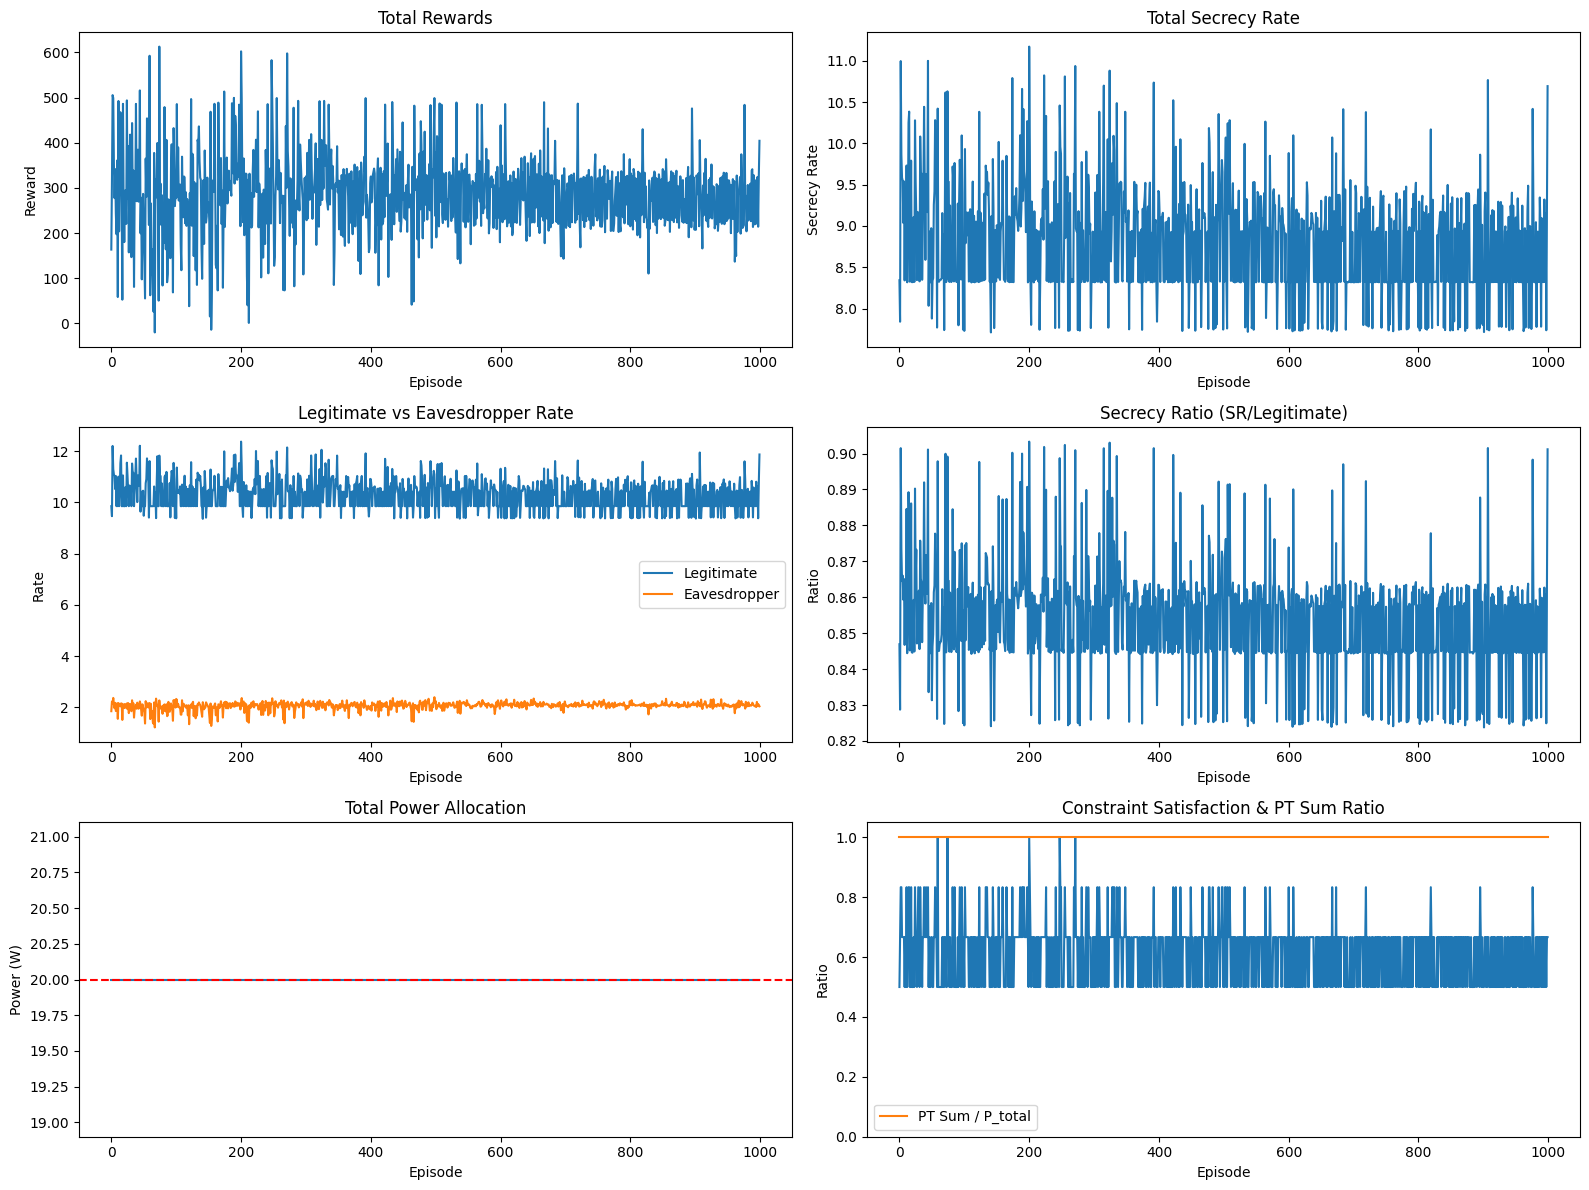

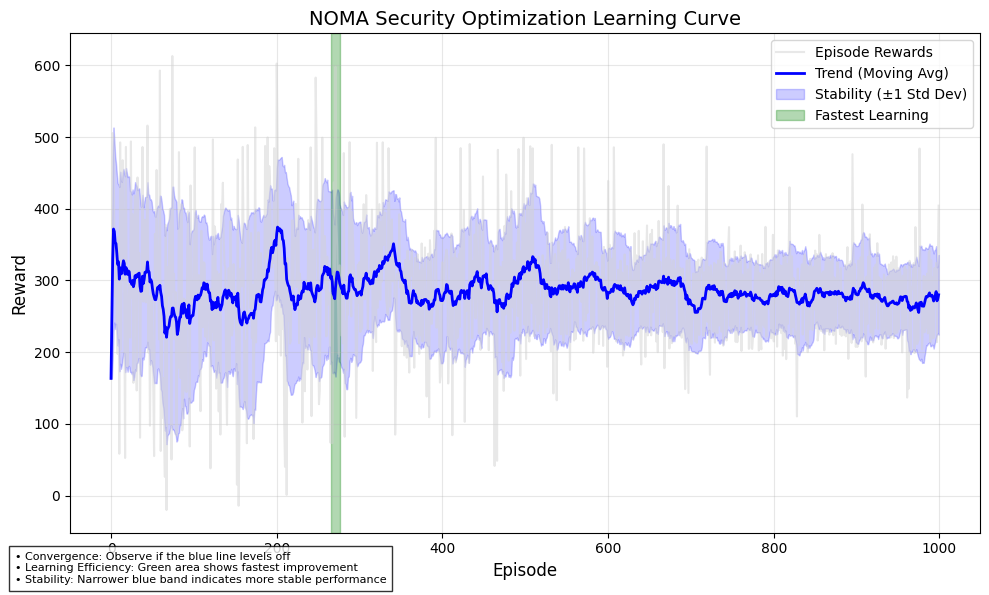

Training completed!


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt

class NomaEnvironment:
    def __init__(self, num_pairs=3, P_total=17, min_power_ratio=0.1, noise_power=1e-6, eavesdropper_scale=0.5, alpha=0.5, mimo_dim=2):
        self.num_pairs = num_pairs
        self.P_total = P_total
        self.min_power_ratio = min_power_ratio
        self.noise_power = noise_power
        self.eavesdropper_scale = eavesdropper_scale
        self.alpha = alpha  # SIC imperfection factor at eavesdropper
        self.mimo_dim = mimo_dim  # Dimension of MIMO channel matrices
        np.random.seed(5)  # Fixed seed for consistent channel gains

        # Initialize dynamic power thresholds (PT1, PT2) and rate thresholds (RT1, RT2)
        self.PT1 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation
        self.PT2 = np.ones(num_pairs) * (P_total / (2 * num_pairs))  # Initial equal allocation

        # Rate thresholds as requested: RT1 = 1.0, RT2 = 0.3
        self.RT1 = np.ones(num_pairs) * 1.0  # Threshold for stronger user
        self.RT2 = np.ones(num_pairs) * 0.3  # Threshold for weaker user

        # Generate channel matrices for each pair
        self.channel_matrices = self.generate_channel_matrices()
        self.reset()

    def generate_channel_matrices(self):
        """Generate MIMO channel matrices for each pair with H1>H2 but H1E<H2E"""
        pairs = []
        pairing_info = []

        for i in range(self.num_pairs):
            # Generate legitimate channel matrices for each pair
            # We'll generate multiple candidates and select those that meet our criteria
            candidates = []
            for _ in range(10):  # Generate multiple candidates
                H1 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
                H2 = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
                H1_gain = self.calculate_channel_gain(H1)
                H2_gain = self.calculate_channel_gain(H2)
                candidates.append((H1, H2, H1_gain, H2_gain))

            # Sort candidates by the ratio H1/H2 (descending) to find the ones with clearest H1>H2
            candidates.sort(key=lambda x: x[2]/x[3], reverse=True)
            H1, H2, H1_gain, H2_gain = candidates[0]  # Take the best candidate

            # Generate eavesdropper channels with H1E<H2E condition
            eve_candidates = []
            for _ in range(10):  # Generate multiple candidates
                H1e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
                H2e = np.abs((np.random.randn(self.mimo_dim, self.mimo_dim) + 1j * np.random.randn(self.mimo_dim, self.mimo_dim)) / np.sqrt(2))
                H1e_gain = self.calculate_channel_gain(H1e)
                H2e_gain = self.calculate_channel_gain(H2e)
                eve_candidates.append((H1e, H2e, H1e_gain, H2e_gain))

            # Sort candidates by the ratio H1E/H2E (ascending) to find the ones with clearest H1E<H2E
            eve_candidates.sort(key=lambda x: x[2]/x[3])
            H1e, H2e, H1e_gain, H2e_gain = eve_candidates[0]  # Take the best candidate

            # Double check the conditions we need
            if H1_gain <= H2_gain:
                # Swap if not meeting our condition
                H1, H2 = H2, H1
                H1_gain = self.calculate_channel_gain(H1)
                H2_gain = self.calculate_channel_gain(H2)

            if H1e_gain >= H2e_gain:
                # Swap if not meeting our condition
                H1e, H2e = H2e, H1e
                H1e_gain = self.calculate_channel_gain(H1e)
                H2e_gain = self.calculate_channel_gain(H2e)

            # Store the final values
            pairs.append((H1, H2, H1e, H2e))
            pairing_info.append((H1_gain, H2_gain, H1e_gain, H2e_gain))

        print("\n===== Channel Gains =====")
        for i, (h1, h2, h1e, h2e) in enumerate(pairing_info):
            print(f"Pair {i+1}:")
            print(f"h1: {h1:.4f} (Stronger legitimate channel)")
            print(f"h2: {h2:.4f} (Weaker legitimate channel)")
            print(f"h1e: {h1e:.4f} (Weaker eavesdropper channel)")
            print(f"h2e: {h2e:.4f} (Stronger eavesdropper channel)")
            print(f"Legitimate ratio (H1/H2): {h1/h2:.4f}")
            print(f"Eavesdropper ratio (H1E/H2E): {h1e/h2e:.4f}")
            print(f"Security condition User 1 (H1/H1E): {h1/h1e:.4f}")
            print(f"Security condition User 2 (H2/H2E): {h2/h2e:.4f}")
            print()

        return pairs

    def calculate_channel_gain(self, H):
        """Calculate channel gain from MIMO channel matrix"""
        return np.real(np.trace(np.matmul(H, H.conj().T))) / H.shape[0]

    def calculate_sinr(self, pair_idx, all_powers):
        """Calculate SINR for legitimate users and eavesdropper with H1>H2 but H1E<H2E"""
        H1, H2, H1e, H2e = self.channel_matrices[pair_idx]
        H1_gain = self.calculate_channel_gain(H1)  # Stronger user to BS
        H2_gain = self.calculate_channel_gain(H2)  # Weaker user to BS
        H1e_gain = self.calculate_channel_gain(H1e)  # Weaker user to Eve
        H2e_gain = self.calculate_channel_gain(H2e)  # Stronger user to Eve

        P1, P2 = all_powers[pair_idx]
        Pn = all_powers[-1][0]  # Last element is Pn

        # SINR at Base Station (no artificial noise impact)
        # For stronger user (decoded first)
        SINR1 = (P1 * (H1_gain**2)) / (P2 * (H2_gain**2) + self.noise_power)

        # For weaker user (decoded second) - after SIC
        SINR2 = (P2 * (H2_gain**2)) / (self.alpha * (P1 * (H1_gain**2)) + self.noise_power)

        # SINR at Eavesdropper (with artificial noise impact)
        # At the eavesdropper, the decoding order would be based on eavesdropper channel gains
        # User 2 has stronger channel to Eve, so it would be decoded first

        # For user with stronger eavesdropper channel (User 2) - decoded first at Eve
        SINR2E = (P2 * (H2e_gain**2)) / (P1 * (H1e_gain**2) + Pn * (H2e_gain**2) + self.noise_power)

        # For user with weaker eavesdropper channel (User 1) - after imperfect SIC at Eve
        SINR1E = (P1 * (H1e_gain**2)) / (Pn * (H1e_gain**2) + self.alpha * P2 * (H2e_gain**2) + self.noise_power)

        return SINR1, SINR2, SINR1E, SINR2E

    def calculate_rates(self, SINR1, SINR2, SINR1E, SINR2E):
        """Calculate achievable rates and secrecy rates"""
        # Legitimate channel rates
        R1 = np.log2(1 + SINR1)
        R2 = np.log2(1 + SINR2)

        # Eavesdropper channel rates
        R1E = np.log2(1 + SINR1E)
        R2E = np.log2(1 + SINR2E)

        # Secrecy rates (non-negative)
        SR1 = np.maximum(0, R1 - R1E)
        SR2 = np.maximum(0, R2E - R2)

        return SR1, SR2, R1, R2, R1E, R2E

    def adjust_power_for_constraints(self, pair_idx, rates, powers, remaining_power):
        """
        Adjust power allocation to prioritize meeting constraints
        Returns: adjusted P1, P2, and remaining power
        """
        SR1, SR2, _, _, _, _ = rates
        P1, P2 = powers[pair_idx]
        PT1, PT2 = self.PT1[pair_idx], self.PT2[pair_idx]
        RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

        power_adjusted = False

        # Check if constraints are met
        deficit1 = max(0, RT1 - SR1)
        deficit2 = max(0, RT2 - SR2)

        # Calculate available headroom for both users
        headroom1 = max(0, PT1 - P1)
        headroom2 = max(0, PT2 - P2)

        # Calculate how much to increase based on deficit
        # The larger the deficit, the larger the increase
        increase_factor = 0.4

        # Since User 1 has worse eavesdropper channel condition (H1E < H2E),
        # prioritize strengthening User 1 more aggressively
        if deficit1 > 0 and headroom1 > 0:
            # User 1 needs more power (stronger user with weaker eavesdropper channel)
            increase_amount = min(remaining_power, headroom1,
                                deficit1 * increase_factor * 1.5 * P1)  # 50% more increase
            if increase_amount > 0:
                P1 += increase_amount
                remaining_power -= increase_amount
                power_adjusted = True

        if deficit2 > 0 and headroom2 > 0:
            # Then user 2 if needed
            increase_amount = min(remaining_power, headroom2,
                                deficit2 * increase_factor * P2)
            if increase_amount > 0:
                P2 += increase_amount
                remaining_power -= increase_amount
                power_adjusted = True

        if deficit2 > 0 and headroom2 >0:
          deficit_ratio = deficit2 / RT2
          increase_factor = 0.5 + 0.2 * deficit_ratio
          increase_amount = min(remaining_power, headroom2, deficit2 * increase_factor * P2)
          if increase_amount > 0:
            P2 += increase_amount
            remaining_power -= increase_amount
            power_adjusted = True

        if deficit1 > 0.3 * RT1 and headroom1 > 0:  # Only if 30% or more below threshold
          increase_amount = min(remaining_power, headroom1,
                              deficit1 * increase_factor * P1)
          if increase_amount > 0:
              P1 += increase_amount
              remaining_power -= increase_amount
              power_adjusted = True

        return P1, P2, remaining_power, power_adjusted
    #-----------------------
    def balance_power_within_pair(self, pair_idx, rates, powers, remaining_power):
        """Transfer power from User 1 to User 2 to meet constraints, maintaining P1 > P2 when possible"""
        SR1, SR2, _, _, _, _ = rates
        P1, P2 = powers
        RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

        # Calculate excess/deficit
        deficit2 = max(0, RT2 - SR2)      # How much User 2 is below threshold
        excess1 = max(0, SR1 - RT1 * 1.2) # How much User 1 exceeds threshold with safety margin

        # When User 2 is below threshold and User 1 has excess
        if deficit2 > 0 and SR1 > RT1 * 1.2:
            # Aggressive transfer - up to 50% of excess from User 1
            power_reduction = min(P1 * 0.5, P1 * excess1 / SR1)

            # Ensure User 1 still has enough power to meet its constraint
            min_p1 = P1 * (RT1 / SR1) * 1.1  # Minimum power for User 1 with 10% safety margin
            if P1 - power_reduction < min_p1:
                power_reduction = P1 - min_p1

            if power_reduction > 0:
                P1 -= power_reduction
                P2 += power_reduction
                print(f"Pair {pair_idx+1}: Transferred {power_reduction:.4f}W from User 1 to User 2")

        # Check if we need to allow P2 > P1 to meet User 2's constraint
        if SR2 < RT2 * 0.9 and P2 <= P1:  # User 2 far below threshold and P2 not greater than P1
            # Estimate how much more power User 2 might need
            power_increase_factor = (RT2 / max(SR2, 0.001)) * 1.2  # 20% safety margin
            estimated_p2_needed = P2 * power_increase_factor

            # If estimated needed P2 would exceed P1, allow it only if necessary for constraint
            if estimated_p2_needed > P1:
                original_p1 = P1
                original_p2 = P2

                # Try with P2 > P1 and see if it helps meet the constraint
                P2 = estimated_p2_needed
                P1 = min(P1, P2 * 0.95)  # Allow P2 to be slightly higher

                print(f"Pair {pair_idx+1}: Testing P2 > P1 (P1: {P1:.4f}, P2: {P2:.4f}) to meet constraint")
            else:
                # Otherwise maintain P1 > P2 NOMA principle
                if P1 <= P2:
                    total_power = P1 + P2
                    P1 = total_power * 0.55  # 55% to User 1
                    P2 = total_power * 0.45  # 45% to User 2
                    print(f"Pair {pair_idx+1}: Maintained NOMA principle with P1={P1:.4f}, P2={P2:.4f}")
        else:
            # In normal case, maintain P1 > P2 for NOMA
            if P1 <= P2:
                total_power = P1 + P2
                P1 = total_power * 0.55  # 55% to User 1
                P2 = total_power * 0.45  # 45% to User 2
                print(f"Pair {pair_idx+1}: Maintained NOMA principle with P1={P1:.4f}, P2={P2:.4f}")

        return P1, P2
    #--------------------------------------
        #---------------------
    def apply_power_constraints(self, powers):
        """Apply power constraints with focus on meeting rate requirements"""
        modified_powers = []

        # For each power allocation pair
        for i in range(len(powers) - 1):
            P1, P2 = powers[i]

            # Apply minimum power constraint
            min_power = self.min_power_ratio * self.P_total / (2 * self.num_pairs)
            P1 = max(P1, min_power)
            P2 = max(P2, min_power)

            # Apply maximum power constraints (PT1, PT2)
            P1 = min(P1, self.PT1[i])
            P2 = min(P2, self.PT2[i])

            # Check if we have recent rate information to determine if constraints are being met
            allow_p2_gt_p1 = False
            if hasattr(self, 'latest_rates') and i < len(self.latest_rates):
                sr1 = self.latest_rates[i][0]
                sr2 = self.latest_rates[i][1]
                rt1 = self.RT1[i]
                rt2 = self.RT2[i]

                # Allow P2 > P1 ONLY if User 2 is below threshold and User 1 exceeds threshold
                allow_p2_gt_p1 = (sr2 < rt2 * 0.8 and sr1 > rt1 * 1.5)

                if allow_p2_gt_p1:
                    print(f"Pair {i+1}: Allowing P2 > P1 to meet User 2's constraint")

            # Enforce P1 > P2 only if not needed to meet constraints
            if not allow_p2_gt_p1 and P1 <= P2:
                total_power = P1 + P2
                P1 = total_power * 0.55  # 55% to stronger user
                P2 = total_power * 0.45  # 45% to weaker user
                print(f"Pair {i+1}: Enforcing NOMA principle: P1={P1:.4f}, P2={P2:.4f}")

            modified_powers.append([P1, P2])

        # Add Pn (noise power) unchanged
        modified_powers.append(powers[-1])

        return modified_powers

    def adjust_thresholds_based_on_necessity(self, rates_info, powers_info):
        """Adjust thresholds based on constraint satisfaction and power usage efficiency"""
        # Check if we're receiving a list of rates for a single pair or for all pairs
        # If it's a single pair, we'll handle it differently
        single_pair_mode = False
        if len(rates_info) == 1 and isinstance(rates_info[0], tuple) and len(rates_info[0]) == 6:
            single_pair_mode = True
            pair_idx = 0  # Default to pair 0 unless specified
            if len(powers_info) == 2 and isinstance(powers_info[1], int):
                pair_idx = powers_info[1]
                powers_info = [powers_info[0]]

            # In single pair mode, rates_info is [(SR1, SR2, R1, R2, R1E, R2E)]
            # and powers_info is [[P1, P2]]
            SR1, SR2, _, _, _, _ = rates_info[0]
            P1, P2 = powers_info[0]
            RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

            # Apply adjustment logic for this specific pair
            threshold_adjustments = []

            # Case 1: User exceeds threshold but just meets constraint
            if P1 > self.PT1[pair_idx] and 1.0 <= (SR1 / RT1) <= 1.2:
                # User needs this power to meet constraint - increase threshold
                adjustment = (P1 * 1.1) - self.PT1[pair_idx]
                threshold_adjustments.append((pair_idx, 0, adjustment))

            if P2 > self.PT2[pair_idx] and 1.0 <= (SR2 / RT2) <= 1.2:
                # User needs this power to meet constraint - increase threshold
                adjustment = (P2 * 1.1) - self.PT2[pair_idx]
                threshold_adjustments.append((pair_idx, 1, adjustment))

            # Case 2: User is using much less power than threshold but meeting constraint
            if P1 < self.PT1[pair_idx] * 0.7 and SR1 >= RT1:
                # User is efficient - can reduce threshold
                adjustment = (P1 * 1.2) - self.PT1[pair_idx]  # Negative adjustment
                threshold_adjustments.append((pair_idx, 0, adjustment))

            if P2 < self.PT2[pair_idx] * 0.7 and SR2 >= RT2:
                # User is efficient - can reduce threshold
                adjustment = (P2 * 1.2) - self.PT2[pair_idx]  # Negative adjustment
                threshold_adjustments.append((pair_idx, 1, adjustment))
        else:
            # Original implementation for multiple pairs
            threshold_adjustments = []

            for i in range(min(len(rates_info), len(powers_info), self.num_pairs)):
                SR1, SR2 = rates_info[i][0], rates_info[i][1]
                RT1, RT2 = self.RT1[i], self.RT2[i]
                P1, P2 = powers_info[i]

                # Case 1: User exceeds threshold but just meets constraint
                if P1 > self.PT1[i] and 1.0 <= (SR1 / RT1) <= 1.2:
                    # User needs this power to meet constraint - increase threshold
                    adjustment = (P1 * 1.1) - self.PT1[i]  # Amount to increase
                    threshold_adjustments.append((i, 0, adjustment))

                if P2 > self.PT2[i] and 1.0 <= (SR2 / RT2) <= 1.2:
                    # User needs this power to meet constraint - increase threshold
                    adjustment = (P2 * 1.1) - self.PT2[i]
                    threshold_adjustments.append((i, 1, adjustment))

                # Case 2: User is using much less power than threshold but meeting constraint
                if P1 < self.PT1[i] * 0.7 and SR1 >= RT1:
                    # User is efficient - can reduce threshold
                    adjustment = (P1 * 1.2) - self.PT1[i]  # Negative adjustment
                    threshold_adjustments.append((i, 0, adjustment))

                if P2 < self.PT2[i] * 0.7 and SR2 >= RT2:
                    # User is efficient - can reduce threshold
                    adjustment = (P2 * 1.2) - self.PT2[i]  # Negative adjustment
                    threshold_adjustments.append((i, 1, adjustment))

        # Apply the adjustments
        for pair_idx, user_idx, adjustment in threshold_adjustments:
            if user_idx == 0:
                self.PT1[pair_idx] += adjustment
                # Ensure minimum threshold
                self.PT1[pair_idx] = max(self.PT1[pair_idx], powers_info[0][0] * 1.05 if single_pair_mode else powers_info[pair_idx][0] * 1.05)
            else:
                self.PT2[pair_idx] += adjustment
                # Ensure minimum threshold
                self.PT2[pair_idx] = max(self.PT2[pair_idx], powers_info[0][1] * 1.05 if single_pair_mode else powers_info[pair_idx][1] * 1.05)

        # After adjustments, normalize to ensure total remains at P_total
        self.normalize_power_thresholds()
    #--------------
        #-----------
    def normalize_power_thresholds(self):
        """Ensure all power thresholds sum to exactly P_total with focus on constraints"""
        # If we have recent rates data, use it to adjust thresholds
        constraint_violation = [False] * self.num_pairs

        if hasattr(self, 'latest_rates'):
            try:
                for i in range(self.num_pairs):
                    sr1 = self.latest_rates[i][0]  # SR1 for this pair
                    sr2 = self.latest_rates[i][1]  # SR2 for this pair
                    rt1 = self.RT1[i]              # RT1 threshold
                    rt2 = self.RT2[i]              # RT2 threshold

                    # Mark pairs where User 2 is below threshold but User 1 exceeds
                    constraint_violation[i] = (sr2 < rt2 and sr1 > rt1 * 1.2)

                    if constraint_violation[i]:
                        # Calculate severity of constraint violation
                        violation_severity = (rt2 - sr2) / rt2  # Higher value = more severe

                        # For severe violations, allow PT2 to exceed PT1
                        if violation_severity > 0.5 and sr1 > rt1 * 2.0:  # User 2 below 50% of target, User 1 exceeds by 100%
                            total = self.PT1[i] + self.PT2[i]
                            # Allow PT2 > PT1 in extreme cases
                            self.PT2[i] = total * 0.55
                            self.PT1[i] = total * 0.45
                            print(f"Pair {i+1}: SEVERE VIOLATION - Allowing PT2 > PT1 to address constraint")
                        else:
                            # For moderate violations, reduce the gap but maintain PT1 > PT2
                            total = self.PT1[i] + self.PT2[i]
                            # Adjust based on violation severity
                            p2_fraction = min(0.49, 0.35 + violation_severity * 0.25)  # Up to 49% to User 2
                            self.PT2[i] = total * p2_fraction
                            self.PT1[i] = total * (1 - p2_fraction)
                            print(f"Pair {i+1}: Adjusted thresholds - PT1: {self.PT1[i]:.4f}, PT2: {self.PT2[i]:.4f}")
                    elif self.PT1[i] <= self.PT2[i]:
                        # For normal cases, maintain PT1 > PT2
                        total = self.PT1[i] + self.PT2[i]
                        self.PT1[i] = total * 0.6  # 60% to User 1
                        self.PT2[i] = total * 0.4  # 40% to User 2
            except Exception as e:
                print(f"Error in threshold adjustment: {e}")

        # Then normalize to ensure total remains at P_total
        total_pt = sum(self.PT1) + sum(self.PT2)

        if abs(total_pt - self.P_total) > 1e-6:  # Check with small tolerance
            # Scale all thresholds proportionally
            scale_factor = self.P_total / total_pt
            self.PT1 = self.PT1 * scale_factor
            self.PT2 = self.PT2 * scale_factor


    def update_power_thresholds(self, pair_idx, sr1, sr2, p1, p2):
        """Update power thresholds (PT1, PT2) based on rate performance with improved reallocation"""
        # Power adjustment factors - more aggressive for User 1 with worse eavesdropper channel
        base_adjustment = 0.1  # Base adjustment factor

        # Deficit-based adjustment for constraint failing users
        sr1_deficit = max(0, self.RT1[pair_idx] - sr1)
        sr2_deficit = max(0, self.RT2[pair_idx] - sr2)

        # Calculate deficit ratio (how far from target)
        sr1_deficit_ratio = sr1_deficit / self.RT1[pair_idx] if self.RT1[pair_idx] > 0 else 0
        sr2_deficit_ratio = sr2_deficit / self.RT2[pair_idx] if self.RT2[pair_idx] > 0 else 0

        # For stronger user (User 1) with worse eavesdropper channel
        if sr1 >= self.RT1[pair_idx] * 1.3:  # Exceeding threshold by 30%
            # User is achieving higher secrecy rate than needed - reduce power threshold
            self.PT1[pair_idx] = max(self.PT1[pair_idx] * (1 - base_adjustment * 0.8),
                                p1 * 1.1)  # Don't reduce below current usage
        elif sr1 < self.RT1[pair_idx]:  # Not meeting threshold - User 1 needs more help
            # Increase power threshold based on how far from target
            # More aggressive increase for User 1 due to worse eavesdropper channel
            increase_factor = base_adjustment * (1 + 2.5 * sr1_deficit_ratio)
            self.PT1[pair_idx] = min(self.PT1[pair_idx] * (1 + increase_factor),
                                self.P_total / self.num_pairs * 1.8)  # Allow up to 1.8x share

        # For weaker user (User 2) with better eavesdropper channel
        if sr2 >= self.RT2[pair_idx] * 1.3:  # Exceeding threshold by 30%
            # User is achieving higher secrecy rate than needed - reduce power threshold more aggressively
            self.PT2[pair_idx] = max(self.PT2[pair_idx] * (1 - base_adjustment * 1.2),
                                p2 * 1.1)  # Don't reduce below current usage
        elif sr2 < self.RT2[pair_idx]:  # Not meeting threshold
            # Increase power threshold based on how far from target
            # Less aggressive for User 2 since it has better eavesdropper channel
            increase_factor = base_adjustment * (1 + 1.5 * sr2_deficit_ratio)
            self.PT2[pair_idx] = min(self.PT2[pair_idx] * (1 + increase_factor),
                                self.P_total / self.num_pairs * 1.2)  # Allow up to 1.2x share

        # More aggressive threshold adjustment when User 1 exceeds and User 2 struggles
        if sr1 >= self.RT1[pair_idx] * 2.0:  # Exceeding threshold by 100%+
            # Reduce power threshold for User 1 more aggressively
            self.PT1[pair_idx] = max(self.PT1[pair_idx] * (1 - base_adjustment * 1.5),
                                p1 * 1.1)  # Reduce threshold more aggressively

        if sr2 < self.RT2[pair_idx] * 0.9:  # User 2 below 90% of target
            # Increase User 2 threshold more aggressively
            increase_factor = base_adjustment * (1 + 3 * sr2_deficit_ratio)  # More aggressive increase
            self.PT2[pair_idx] = min(self.PT2[pair_idx] * (1 + increase_factor),
                                self.P_total / self.num_pairs * 1.5)  # Allow higher threshold

        # Enforce NOMA principle - Adjust power thresholds to ensure PT1 > PT2
        total_threshold = self.PT1[pair_idx] + self.PT2[pair_idx]
        self.PT1[pair_idx] = total_threshold * 0.6  # Give stronger user advantage
        self.PT2[pair_idx] = total_threshold * 0.4

        # Normalize thresholds periodically to ensure total is P_total
        # This is now handled by normalize_power_thresholds() called after all updates

    def calculate_constraint_reward(self, rates, pair_idx):
        """
        Calculate rewards specifically focused on meeting constraints.
        Can be called within the step function's reward calculation.
        """
        SR1, SR2, R1, R2, R1E, R2E = rates
        RT1, RT2 = self.RT1[pair_idx], self.RT2[pair_idx]

        # Base constraint reward/penalty
        constraint_weight = 50  # Very high weight to force constraint satisfaction
        constraint_reward = 0

        # Calculate how close each user is to meeting its constraint
        sr1_ratio = SR1 / RT1 if RT1 > 0 else 1.0
        sr2_ratio = SR2 / RT2 if RT2 > 0 else 1.0

        # For stronger user (User 1) with worse eavesdropper channel
        if sr1_ratio >= 1.0:  # Constraint met
            # Higher reward for User 1 meeting constraint since it has worse eavesdropper channel
            constraint_reward += constraint_weight * min(1.7, sr1_ratio)  # Increased reward
        else:
            # Severe penalty for not meeting constraint (increases exponentially as we get further from target)
            deficit_factor = (1 - sr1_ratio) ** 2  # Squared to increase penalty for larger deficits
            constraint_reward -= constraint_weight * 2.5 * deficit_factor  # Increased penalty

        # For weaker user (User 2) with better eavesdropper channel
        if sr2_ratio >= 1.0:  # Constraint met
            # Modest reward for meeting constraint
            constraint_reward += constraint_weight * min(1.3, sr2_ratio)
        else:
            # Penalty for not meeting constraint
            deficit_factor = (1 - sr2_ratio) ** 2
            constraint_reward -= constraint_weight * 1.8 * deficit_factor

        # Global constraint satisfaction bonus
        # If all constraints in this pair are met, add a bonus
        if sr1_ratio >= 1.0 and sr2_ratio >= 1.0:
            constraint_reward += constraint_weight * 0.8  # Increased bonus for meeting both

        return constraint_reward

    def balance_secrecy_rates(self, rates, powers):
        """Balance secrecy rates across users while ensuring constraints are met"""
        all_sr = []
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]
            all_sr.extend([SR1, SR2])

        # Calculate mean secrecy rate
        mean_sr = sum(all_sr) / len(all_sr)

        # Identify users with much higher secrecy rates than average
        for i in range(self.num_pairs):
            SR1, SR2 = rates[i][0], rates[i][1]
            RT1, RT2 = self.RT1[i], self.RT2[i]

            # First ensure constraints are met
            if SR1 < RT1 and SR2 > RT2 * 1.3:
                # User 2 has excess, User 1 needs help - prioritize User 1
                power_shift = min(powers[i][1] * 0.3, powers[i][1] * (SR2 - RT2 * 1.2) / SR2)
                powers[i][0] += power_shift
                powers[i][1] -= power_shift
                print(f"Pair {i+1}: Balance - Shifted {power_shift:.4f}W from User 2 to User 1")

            # Only reduce power for users greatly exceeding average if constraints are met
            if SR1 > RT1 * 1.5 and SR1 > mean_sr * 1.3:
                # Reduce power for User 1 (will be redistributed later)
                reduction = min(powers[i][0] * 0.1, powers[i][0] * (SR1 - RT1 * 1.3) / SR1)
                powers[i][0] -= reduction

            if SR2 > RT2 * 1.5 and SR2 > mean_sr * 1.3:
                # Reduce power for User 2 (will be redistributed later)
                reduction = min(powers[i][1] * 0.15, powers[i][1] * (SR2 - RT2 * 1.3) / SR2)
                powers[i][1] -= reduction

        # Find users that need more power to meet constraints
        # and redistribute the saved power
        saved_power = self.P_total - (sum(sum(p) for p in powers[:-1]) + powers[-1][0])

        if saved_power > 0:
            # Redistribute to users not meeting constraints, prioritizing User 1 with worse Eve channel
            for i in range(self.num_pairs):
                SR1, SR2 = rates[i][0], rates[i][1]
                RT1, RT2 = self.RT1[i], self.RT2[i]

                deficit1 = max(0, RT1 - SR1)
                deficit2 = max(0, RT2 - SR2)

                # User 1 gets higher priority due to worse eavesdropper channel
                if deficit1 > 0:
                    increase = min(saved_power, deficit1 * powers[i][0] * 0.4)
                    powers[i][0] += increase
                    saved_power -= increase

                if deficit2 > 0 and saved_power > 0:
                    increase = min(saved_power, deficit2 * powers[i][1] * 0.25)
                    powers[i][1] += increase
                    saved_power -= increase

            # If power still remains, add to artificial noise
            if saved_power > 0:
                powers[-1][0] += saved_power

        # Ensure NOMA principle P1 > P2 is maintained
        for i in range(self.num_pairs):
            if powers[i][0] <= powers[i][1]:
                total_power = powers[i][0] + powers[i][1]
                powers[i][0] = total_power * 0.6
                powers[i][1] = total_power * 0.4
                print(f"Pair {i+1}: Fixed NOMA ordering: P1={powers[i][0]:.4f}, P2={powers[i][1]:.4f}")

        return powers
    #------------------

    def step(self, actions):
        """Take a step in the environment based on actions with improved constraint handling"""
        # Extract Pn from actions
        pn_contributions = [a[-1] for a in actions]
        pn_value = np.mean(pn_contributions)  # Average of all Pn contributions

        # Enforce minimum Pn constraint (adjusted to ensure it's not too small)
        # Higher minimum for artificial noise to protect User 1 with worse Eve channel
        min_pn = 0.07 * self.P_total  # 7% of total power for artificial noise
        pn_value = max(pn_value, min_pn)

        # Create user power allocations without Pn
        user_powers = [a[:-1] for a in actions]

        # Create final power allocation list
        all_powers = user_powers + [[pn_value]]

        # Apply power constraints (P1 <= PT1, P2 <= PT2)
        all_powers = self.apply_power_constraints(all_powers)

        # Calculate initial SINRs and rates for all pairs
        initial_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            rates = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            initial_rates.append(rates)

        # First scaling to make sure we allocate reasonable power amounts
        scaling_factor = 4.0  # Higher initial scaling to allocate more power
        for i in range(len(all_powers) - 1):
            all_powers[i] = [p * scaling_factor for p in all_powers[i]]
        all_powers[-1] = [all_powers[-1][0] * scaling_factor]

        # Reserve power for adjustments
        remaining_power = self.P_total * 0.2  # Reserve 20% for adjustments
        power_adjustments_made = False

        # PHASE 1: First pass - Identify and fix constraint violations
        for i in range(self.num_pairs):
            SR1, SR2 = initial_rates[i][0], initial_rates[i][1]

            # Check if constraints are met
            if SR1 < self.RT1[i] or SR2 < self.RT2[i]:
                # Adjust power for this pair
                P1, P2, remaining_power, adjusted = self.adjust_power_for_constraints(
                    i, initial_rates[i], all_powers, remaining_power
                )

                if adjusted:
                    all_powers[i][0] = P1
                    all_powers[i][1] = P2
                    power_adjustments_made = True

        # PHASE 2: Second pass - Balance power within pairs
        for i in range(self.num_pairs):
            # Recalculate rates after first phase adjustments
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            current_rates = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)

            # Apply the balance_power_within_pair function
            P1, P2 = self.balance_power_within_pair(i, current_rates, all_powers[i], remaining_power)
            all_powers[i][0] = P1
            all_powers[i][1] = P2

        # PHASE 3: Special handling for pairs with severe constraint issues
        # Identify any pairs where User 1 (with worse Eve channel) is struggling significantly
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            pair_rates = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            SR1, SR2 = pair_rates[0], pair_rates[1]

            if SR1 < self.RT1[i] * 0.7 and SR2 > self.RT2[i]:  # User 1 severely below threshold
                # More aggressive power shift to User 1
                power_to_shift = min(all_powers[i][1] * 0.3, 1.0)  # Shift up to 30% of P2
                all_powers[i][0] += power_to_shift  # Add to P1
                all_powers[i][1] -= power_to_shift  # Subtract from P2
                print(f"Emergency fix for Pair {i+1}: Shifted {power_to_shift:.4f}W from User 2 to User 1")

        # PHASE 4: Ensure powers don't exceed thresholds
        # Apply strict threshold enforcement before normalization
        for i in range(self.num_pairs):
            all_powers[i][0] = min(all_powers[i][0], self.PT1[i])
            all_powers[i][1] = min(all_powers[i][1], self.PT2[i])

        # PHASE 5: Balance secrecy rates across users
        # Recalculate all rates after power adjustments
        updated_rates = []
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            rates = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            updated_rates.append(rates)

        # Balance secrecy rates to avoid large disparities
        all_powers = self.balance_secrecy_rates(updated_rates, all_powers)

        # Enforce NOMA principle: P1 > P2 for H1 > H2
        for i in range(self.num_pairs):
            if all_powers[i][0] <= all_powers[i][1]:
                # Before enforcing NOMA ordering, check current constraint satisfaction
                SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
                SR1, SR2, _, _, _, _ = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)

                # Store original power allocation
                original_p1 = all_powers[i][0]
                original_p2 = all_powers[i][1]

                # Try enforcing NOMA principle
                total_pair_power = original_p1 + original_p2
                new_p1 = total_pair_power * 0.6  # 60% to stronger user
                new_p2 = total_pair_power * 0.4  # 40% to weaker user

                # Temporarily apply new power allocation
                all_powers[i][0] = new_p1
                all_powers[i][1] = new_p2

                # Check if this would cause constraint violations
                SINR1_new, SINR2_new, SINR1E_new, SINR2E_new = self.calculate_sinr(i, all_powers)
                SR1_new, SR2_new, _, _, _, _ = self.calculate_rates(SINR1_new, SINR2_new, SINR1E_new, SINR2E_new)

                # If the new allocation would cause User 2 to not meet constraint, find a balanced solution
                if SR2_new < self.RT2[i] and SR2 >= self.RT2[i]:
                    print(f"NOMA enforcement for Pair {i+1} would cause constraint violation.")

                    # Try a more gradual adjustment that maintains constraint satisfaction
                    for split_ratio in [0.52, 0.54, 0.56, 0.58]:
                        test_p1 = total_pair_power * split_ratio
                        test_p2 = total_pair_power * (1 - split_ratio)

                        all_powers[i][0] = test_p1
                        all_powers[i][1] = test_p2

                        test_SINR1, test_SINR2, test_SINR1E, test_SINR2E = self.calculate_sinr(i, all_powers)
                        test_SR1, test_SR2, _, _, _, _ = self.calculate_rates(test_SINR1, test_SINR2, test_SINR1E, test_SINR2E)

                        if test_SR2 >= self.RT2[i]:
                            print(f"Found balanced solution for Pair {i+1}: P1={test_p1:.4f}, P2={test_p2:.4f}, SR2={test_SR2:.4f}")
                            break

                        # If we reach the end without finding a solution, revert to original
                        if split_ratio == 0.58 and test_SR2 < self.RT2[i]:
                            all_powers[i][0] = original_p1
                            all_powers[i][1] = original_p2
                            print(f"Reverted to original for Pair {i+1} to maintain constraint satisfaction")
                else:
                    print(f"Enforcing NOMA principle for Pair {i+1}: Adjusted P1={new_p1:.4f}, P2={new_p2:.4f}")

        # Calculate total power before normalization
        current_total_power = sum(sum(p) for p in all_powers[:-1]) + all_powers[-1][0]

        # Normalize to exactly meet total power constraint (20W)
        if abs(current_total_power - self.P_total) > 1e-6:
            scale_factor = self.P_total / current_total_power
            for i in range(len(all_powers)):
                if i < len(all_powers) - 1:  # User powers
                    all_powers[i] = [p * scale_factor for p in all_powers[i]]
                else:  # Noise power
                    all_powers[i] = [all_powers[i][0] * scale_factor]

        # Verify total power is exactly 20W
        total_power = sum(sum(p) for p in all_powers[:-1]) + all_powers[-1][0]
        print(f"Total power allocation: {total_power:.4f}W")

        # Final rate calculation and reward calculation after power adjustments
        rewards = []
        states = []
        rates_list = []  # Create a proper list to store all rates

        total_sr = 0
        total_legitimate_rate = 0
        total_eavesdropper_rate = 0

        # Final check and adjustment to ensure power allocations don't exceed thresholds
        for i in range(self.num_pairs):
            if all_powers[i][0] > self.PT1[i] or all_powers[i][1] > self.PT2[i]:
                all_powers[i][0] = min(all_powers[i][0], self.PT1[i])
                all_powers[i][1] = min(all_powers[i][1], self.PT2[i])
                # Re-normalize after this adjustment (localized to this pair)
                pair_power = sum(all_powers[i])
                target_power = self.PT1[i] + self.PT2[i]
                if pair_power < target_power:
                    # If we're under the threshold, scale up proportionally
                    scale = target_power / pair_power
                    all_powers[i] = [p * scale for p in all_powers[i]]

        # Final rate calculation with adjusted powers
        for i in range(self.num_pairs):
            SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
            sr1, sr2, r1, r2, r1e, r2e = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
            rates_list.append((sr1, sr2, r1, r2, r1e, r2e))  # Store as tuple in our list

        # Emergency rebalancing to ensure constraint satisfaction
        needs_rebalancing = False

        # Check if any User 2 is still below threshold
        for i in range(self.num_pairs):
            sr1, sr2 = rates_list[i][0], rates_list[i][1]  # Access from our rates_list

            if sr2 < self.RT2[i] * 0.9 and sr1 > self.RT1[i] * 1.3:
                needs_rebalancing = True
                break

        if needs_rebalancing:
            print("Performing emergency rebalancing to meet User 2 constraints")
            # Store original power allocations
            original_powers = [[p1, p2] for p1, p2 in [all_powers[i] for i in range(self.num_pairs)]]

            # Try emergency rebalancing
            for i in range(self.num_pairs):
                sr1, sr2 = rates_list[i][0], rates_list[i][1]  # Access from our rates_list
                rt1 = self.RT1[i]
                rt2 = self.RT2[i]

                if sr2 < rt2 and sr1 > rt1 * 1.2:
                    # Estimate excess power as proportional to excess SR
                    excess_ratio = (sr1 - rt1 * 1.2) / sr1
                    excess_power = all_powers[i][0] * excess_ratio * 0.7  # Take 70% of the estimated excess

                    all_powers[i][0] -= excess_power
                    all_powers[i][1] += excess_power

                    # Test if this helps User 2 meet constraints, and if User 1 still meets its constraint
                    SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
                    new_sr1, new_sr2, _, _, _, _ = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)

                    # If this causes User 1 to drop below its constraint, partially revert
                    if new_sr1 < rt1:
                        # Revert partially to ensure User 1 meets constraint
                        restore_power = excess_power * 0.5  # Restore 50% of the excess
                        all_powers[i][0] += restore_power
                        all_powers[i][1] -= restore_power
                        print(f"Emergency: Partially reverted transfer for Pair {i+1} to maintain User 1 constraint")
                    elif new_sr2 >= rt2:
                        # Transfer succeeded in meeting User 2's constraint
                        print(f"Emergency: Successfully transferred {excess_power:.4f}W from User 1 to User 2 in Pair {i+1}")
                        print(f"New rates - SR1: {new_sr1:.4f}, SR2: {new_sr2:.4f}")
                    else:
                        # If User 2 still below threshold, consider more extreme measures
                        if new_sr2 < rt2 * 0.8:
                            # Allow P2 > P1 as a last resort
                            total_power = all_powers[i][0] + all_powers[i][1]
                            p1_min = total_power * 0.4  # User 1 gets at least 40%
                            p2_max = total_power * 0.6  # User 2 gets at most 60%

                            # Ensure User 1 can still meet its constraint
                            min_p1_needed = original_powers[i][0] * (rt1 / max(sr1, 0.001)) * 1.1

                            if min_p1_needed < p1_min:
                                # Safe to allocate more to User 2
                                all_powers[i][0] = p1_min
                                all_powers[i][1] = p2_max
                                print(f"EXTREME MEASURE: Allowing P2 > P1 for Pair {i+1} to meet User 2 constraint")
                            else:
                                # Still ensure User 1 gets enough
                                all_powers[i][0] = min_p1_needed
                                all_powers[i][1] = total_power - min_p1_needed

            # Recalculate rates after emergency rebalancing
            for i in range(self.num_pairs):
                SINR1, SINR2, SINR1E, SINR2E = self.calculate_sinr(i, all_powers)
                sr1, sr2, r1, r2, r1e, r2e = self.calculate_rates(SINR1, SINR2, SINR1E, SINR2E)
                rates_list[i] = (sr1, sr2, r1, r2, r1e, r2e)  # Update in our rates_list

        # Calculate rewards for each pair
        for i in range(self.num_pairs):
            sr1, sr2, r1, r2, r1e, r2e = rates_list[i]  # Use our properly structured rates_list

            # Adjust thresholds based on whether users need more power to meet constraints
            self.adjust_thresholds_based_on_necessity([(sr1, sr2, r1, r2, r1e, r2e)], [all_powers[i], i])

            # Calculate base reward as secrecy rate sum
            reward = sr1 + sr2

            # Add reward component for maximizing the gap between legitimate and eavesdropper rates
            legitimate_rate = r1 + r2
            eavesdropper_rate = r1e + r2e
            security_gap = legitimate_rate - eavesdropper_rate
            reward += 2 * security_gap  # Give extra weight to increasing the gap

            # Reward to increase security ratio Secrecy/Legitimate
            if legitimate_rate > 0:
                reward += 2 * (security_gap / legitimate_rate)

            # Add constraint-focused reward (much higher weight for constraint satisfaction)
            constraint_reward = self.calculate_constraint_reward((sr1, sr2, r1, r2, r1e, r2e), i)
            reward += constraint_reward

            # Reward or penalize based on power allocation vs threshold
            # Reward efficient use of power
            p1_usage_ratio = all_powers[i][0] / self.PT1[i]
            p2_usage_ratio = all_powers[i][1] / self.PT2[i]

            # If user is using less than threshold but meeting constraint, reward efficiency
            if p1_usage_ratio < 0.9 and sr1 >= self.RT1[i]:
                reward += 5 * (1 - p1_usage_ratio)
            if p2_usage_ratio < 0.9 and sr2 >= self.RT2[i]:
                reward += 5 * (1 - p2_usage_ratio)

            # If user is at threshold limit but barely meeting constraint, penalize inefficiency
            if p1_usage_ratio > 0.95 and 1.0 <= (sr1 / self.RT1[i]) <= 1.1:
                reward -= 3
            if p2_usage_ratio > 0.95 and 1.0 <= (sr2 / self.RT2[i]) <= 1.1:
                reward -= 3

            # Penalize zero secrecy rate more heavily
            if sr1 == 0 or sr2 == 0:
                reward -= 15

            # Add channel-gain based power allocation reward
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)  # Stronger user
            H2_gain = self.calculate_channel_gain(H2)  # Weaker user
            H1e_gain = self.calculate_channel_gain(H1e)  # Weaker eve channel
            H2e_gain = self.calculate_channel_gain(H2e)  # Stronger eve channel

            # Enhanced reward to encourage more power to strong user for uplink NOMA
            power_ratio = all_powers[i][0] / (all_powers[i][0] + all_powers[i][1] + 1e-10)
            gain_ratio = H1_gain / (H2_gain + 1e-10)

            # Channel-aware power allocation reward
            ideal_ratio = gain_ratio / (1 + gain_ratio)  # Transform gain ratio to power ratio

            # Reward for power allocation that matches channel conditions
            power_alignment_penalty = 5 * abs(power_ratio - ideal_ratio)
            reward -= power_alignment_penalty

            # Add special reward for mitigating the disadvantage for User 1 with worse Eve channel
            eve_challenge_ratio = H1e_gain / H2e_gain  # Lower is better for User 1's security
            if eve_challenge_ratio < 0.7:  # User 1 has significantly worse Eve channel
                # Reward higher power to User 1 and higher artificial noise
                if p1_usage_ratio > 0.7 and all_powers[-1][0] > 0.1 * self.P_total:
                    reward += 8 * (1 - eve_challenge_ratio)  # More reward when the challenge is greater

            # Add rewards for effective artificial noise allocation
            pn_ratio = all_powers[-1][0] / self.P_total

            # Calculate average eavesdropper channel strength
            eve_strength_ratio = (H1e_gain + H2e_gain) / (H1_gain + H2_gain)

            if eve_strength_ratio > 0.3:  # Eavesdropper is relatively strong
                if pn_ratio > 0.2:  # More noise is better against strong eavesdroppers
                    reward += 5 * pn_ratio
            else:  # Eavesdropper is relatively weak
                # Reward moderate noise for weak eavesdroppers
                if 0.1 < pn_ratio < 0.2:
                    reward += 3

            #total_sr += sr1 + sr2
            total_sr +=sr1
            total_legitimate_rate += r1 + r2

            total_eavesdropper_rate += r1e + r2e
            rewards.append(reward)

            # State for each pair (extended to include power thresholds and usage)
            state = [
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                all_powers[i][0]/self.P_total,  # Normalized P1
                all_powers[i][1]/self.P_total,  # Normalized P2
                all_powers[-1][0]/self.P_total,  # Global Pn
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                sr1 - self.RT1[i],  # Secrecy rate gap from threshold (user 1)
                sr2 - self.RT2[i]   # Secrecy rate gap from threshold (user 2)
            ]
            states.append(state)

        # Ensure all thresholds sum to exactly P_total after this step
        self.normalize_power_thresholds()

        # Final verification of threshold sum
        pt_sum = sum(self.PT1) + sum(self.PT2)
        print(f"Sum of all power thresholds: {pt_sum:.4f}W")

        # Store the latest rates for use in future adjustments - store as list of tuples
        self.latest_rates = rates_list

        # FINAL CHECK: Ensure total power is exactly P_total
        final_total_power = sum(sum(p) for p in all_powers[:-1]) + all_powers[-1][0]
        if abs(final_total_power - self.P_total) > 1e-10:  # Stricter tolerance
            final_scale = self.P_total / final_total_power
            for i in range(len(all_powers)):
                if i < len(all_powers) - 1:
                    all_powers[i] = [p * final_scale for p in all_powers[i]]
                else:
                    all_powers[i] = [all_powers[i][0] * final_scale]

        # Print confirmation of power adjustment
        #print(f"Applied final power normalization: {final_total_power:.4f}W → {self.P_total:.4f}W")

        return states, rewards, total_sr, rates_list, all_powers, total_legitimate_rate, total_eavesdropper_rate

    def reset(self):
        """Reset environment for new episode with improved initial allocations"""
        # Better initial power thresholds based on channel conditions
        self.PT1 = np.zeros(self.num_pairs)
        self.PT2 = np.zeros(self.num_pairs)

        # Analyze channel gains to set initial power thresholds
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)  # Stronger user to BS
            H2_gain = self.calculate_channel_gain(H2)  # Weaker user to BS
            H1e_gain = self.calculate_channel_gain(H1e)  # Weaker user to Eve
            H2e_gain = self.calculate_channel_gain(H2e)  # Stronger user to Eve

            # Calculate channel ratios to determine power needs
            legitimate_ratio = H1_gain / H2_gain  # How much stronger is User 1
            eve_ratio1 = H1_gain / (H1e_gain + 1e-10)  # User 1 legitimate vs eve channel
            eve_ratio2 = H2_gain / (H2e_gain + 1e-10)  # User 2 legitimate vs eve channel

            # Calculate baseline power per pair
            pair_power = self.P_total / self.num_pairs

            # Allocate power based on security conditions and NOMA principles
            # Since H1E < H2E, User 1 needs more protection with power and artificial noise
            security_challenge1 = eve_ratio1  # Higher is better
            security_challenge2 = eve_ratio2  # Higher is better

            # User 1 should get more power due to:
            # 1. NOMA principle (H1 > H2)
            # 2. Security challenge (H1E < H2E)
            if security_challenge1 < security_challenge2:
                # User 1 has worse security condition
                self.PT1[i] = pair_power * 0.65  # Give more power to user with security challenge
                self.PT2[i] = pair_power * 0.35
            else:
                # Standard NOMA power allocation
                self.PT1[i] = pair_power * 0.6
                self.PT2[i] = pair_power * 0.4

            # Further adjust based on RT1 and RT2 thresholds
            # If RT1 is higher than RT2, allocate more power to User 1
            rt_ratio = self.RT1[i] / (self.RT2[i] + 1e-10)
            if rt_ratio > 2:  # RT1 is much higher than RT2
                total_power = self.PT1[i] + self.PT2[i]
                self.PT1[i] = total_power * 0.7
                self.PT2[i] = total_power * 0.3

        # Ensure all thresholds sum to exactly P_total
        self.normalize_power_thresholds()

        initial_states = []
        for i in range(self.num_pairs):
            H1, H2, H1e, H2e = self.channel_matrices[i]
            H1_gain = self.calculate_channel_gain(H1)
            H2_gain = self.calculate_channel_gain(H2)
            H1e_gain = self.calculate_channel_gain(H1e)
            H2e_gain = self.calculate_channel_gain(H2e)

            # More realistic initial power allocation based on thresholds
            p1_ratio = self.PT1[i] / self.P_total
            p2_ratio = self.PT2[i] / self.P_total
            pn_ratio = 0.2  # Initial noise ratio

            initial_states.append([
                H1_gain, H2_gain, H1e_gain, H2e_gain,
                p1_ratio, p2_ratio, pn_ratio,  # Initial power allocations
                self.PT1[i]/self.P_total,  # Normalized PT1
                self.PT2[i]/self.P_total,  # Normalized PT2
                -self.RT1[i],  # Initial gap (negative because we start below threshold)
                -self.RT2[i]   # Initial gap (negative because we start below threshold)
            ])
        return initial_states


class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim + 1)  # +1 for Pn contribution

        # Initialize with different weights to encourage diversity
        self.fc3.weight.data.uniform_(-0.003, 0.003)
        self.fc3.bias.data.uniform_(-0.003, 0.003)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        raw_output = self.fc3(x)

        # Check if we're dealing with a single sample or a batch
        if raw_output.dim() == 1:
            # Single sample case - Modified to prioritize users based on constraints and channel conditions
            # Check state[9] (SR1 gap) and state[10] (SR2 gap)
            h1e = state[2]  # H1e gain (weaker to eavesdropper)
            h2e = state[3]  # H2e gain (stronger to eavesdropper)

            # Calculate security challenge ratio (lower means User 1 faces bigger challenge)
            security_challenge = h1e / (h2e + 1e-10)

            if state[9] < 0:  # User 1 is not meeting constraint
                # Give extra power to user 1, especially if security challenge is high
                p1 = torch.sigmoid(raw_output[0]) * (1.7 - 0.3 * min(1, security_challenge))
                p2 = torch.sigmoid(raw_output[1]) * 1.0
                pn = torch.sigmoid(raw_output[2]) * (0.8 - 0.3 * min(1, security_challenge))
            elif state[10] < 0:  # User 2 is not meeting constraint
                # Give extra power to user 2
                p1 = torch.sigmoid(raw_output[0]) * 1.2
                p2 = torch.sigmoid(raw_output[1]) * 1.4
                pn = torch.sigmoid(raw_output[2]) * 0.6
            else:
                # Both meeting constraints - allocate based on NOMA principle and security challenge
                p1 = torch.sigmoid(raw_output[0]) * (1.5 - 0.3 * min(1, security_challenge))
                p2 = torch.sigmoid(raw_output[1]) * 1.1
                pn = torch.sigmoid(raw_output[2]) * 0.6

            # Check if allocated power is within threshold
            pt1 = state[7] * 20  # PT1 normalized * total power
            pt2 = state[8] * 20  # PT2 normalized * total power

            # Ensure we don't exceed thresholds
            p1 = min(p1, pt1)
            p2 = min(p2, pt2)

            return torch.tensor([p1, p2, pn])
        else:
            # Batch case
            # For batches, we need to individually evaluate each sample
            p1_list = []
            p2_list = []
            pn_list = []

            for i in range(raw_output.shape[0]):
                h1e = state[i, 2]  # H1e gain
                h2e = state[i, 3]  # H2e gain
                security_challenge = h1e / (h2e + 1e-10)

                if state[i, 9] < 0:  # User 1 not meeting constraint
                    p1 = torch.sigmoid(raw_output[i, 0]) * (1.7 - 0.3 * min(1, security_challenge))
                    p2 = torch.sigmoid(raw_output[i, 1]) * 1.0
                    pn = torch.sigmoid(raw_output[i, 2]) * (0.8 - 0.3 * min(1, security_challenge))
                elif state[i, 10] < 0:
                    p1 = torch.sigmoid(raw_output[i, 0]) * 1.2
                    p2 = torch.sigmoid(raw_output[i, 1]) * 1.4
                    pn = torch.sigmoid(raw_output[i, 2]) * 0.6
                else:
                    p1 = torch.sigmoid(raw_output[i, 0]) * (1.5 - 0.3 * min(1, security_challenge))
                    p2 = torch.sigmoid(raw_output[i, 1]) * 1.1
                    pn = torch.sigmoid(raw_output[i, 2]) * 0.6

                # Ensure within thresholds
                pt1 = state[i, 7] * 20  # PT1
                pt2 = state[i, 8] * 20  # PT2
                p1 = min(p1, pt1)
                p2 = min(p2, pt2)

                p1_list.append(p1)
                p2_list.append(p2)
                pn_list.append(pn)

            return torch.stack([
                torch.tensor(p1_list),
                torch.tensor(p2_list),
                torch.tensor(pn_list)
            ], dim=1)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, num_pairs):
        super(Critic, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim + 1  # +1 for Pn
        self.num_pairs = num_pairs

        # Total input size for all pairs combined
        self.total_input_size = (state_dim + action_dim + 1) * num_pairs

        self.fc1 = nn.Linear(self.total_input_size, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, states, actions):
        # Combine states and actions
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class MultiAgentDDPG:
    def __init__(self, num_pairs, state_dim, action_dim):
        self.num_pairs = num_pairs
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize networks
        self.actors = [Actor(state_dim, action_dim).to(self.device) for _ in range(num_pairs)]
        self.actor_targets = [Actor(state_dim, action_dim).to(self.device) for _ in range(num_pairs)]

        # Initialize critic networks (shared critic for centralized training)
        self.critic = Critic(state_dim, action_dim, num_pairs).to(self.device)
        self.critic_target = Critic(state_dim, action_dim, num_pairs).to(self.device)

        # Copy initial weights
        for i in range(num_pairs):
            self.actor_targets[i].load_state_dict(self.actors[i].state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())

        # Initialize optimizers with higher learning rates
        self.actor_optimizers = [optim.Adam(self.actors[i].parameters(), lr=3e-4) for i in range(num_pairs)]
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=3e-3)

        # Replay buffer
        self.memory = deque(maxlen=100000)

        # Hyperparameters
        self.batch_size = 128  # Increased from 64
        self.gamma = 0.995  # Discount factor
        self.tau = 0.015  # Increased from 0.01 for faster target network updates

        # Exploration noise parameters with higher initial noise for better exploration
        self.noise_scale = 0.35  # Increased from 0.1
        self.noise_decay = 0.998  # Slower decay
        self.min_noise = 0.07  # Higher minimum noise level

    def select_action(self, states, add_noise=True):
        """Select actions for all agents based on current policy"""
        actions = []

        for i in range(self.num_pairs):
            state = torch.FloatTensor(states[i]).to(self.device)
            action = self.actors[i](state).cpu().detach().numpy()

            if add_noise:
                # Add exploration noise
                noise = np.random.normal(0, self.noise_scale, size=self.action_dim + 1)
                action = np.clip(action + noise, 0, 1)

            actions.append(action)

        return actions

    def remember(self, states, actions, rewards, next_states):
        """Store experience in replay buffer"""
        self.memory.append((states, actions, rewards, next_states))

    def update_noise(self):
        """Decay exploration noise"""
        self.noise_scale = max(self.min_noise, self.noise_scale * self.noise_decay)

    def update(self):
        """Update actor and critic networks"""
        if len(self.memory) < self.batch_size:
            return

        # Sample random batch from replay buffer
        batch = random.sample(self.memory, self.batch_size)

        # Extract batch data
        states_batch = [[] for _ in range(self.num_pairs)]
        actions_batch = [[] for _ in range(self.num_pairs)]
        rewards_batch = [[] for _ in range(self.num_pairs)]
        next_states_batch = [[] for _ in range(self.num_pairs)]

        for experience in batch:
            states, actions, rewards, next_states = experience

            for i in range(self.num_pairs):
                states_batch[i].append(states[i])
                actions_batch[i].append(actions[i])
                rewards_batch[i].append(rewards[i])
                next_states_batch[i].append(next_states[i])

        # Convert to tensors
        states_tensor = [torch.FloatTensor(np.array(states_batch[i])).to(self.device)
                         for i in range(self.num_pairs)]
        actions_tensor = [torch.FloatTensor(np.array(actions_batch[i])).to(self.device)
                          for i in range(self.num_pairs)]
        rewards_tensor = [torch.FloatTensor(np.array(rewards_batch[i])).to(self.device)
                          for i in range(self.num_pairs)]
        next_states_tensor = [torch.FloatTensor(np.array(next_states_batch[i])).to(self.device)
                              for i in range(self.num_pairs)]

        # Update critic
        self._update_critic(states_tensor, actions_tensor, rewards_tensor, next_states_tensor)

        # Update actors
        self._update_actors(states_tensor)

        # Update target networks
        self._update_targets()

    def _update_critic(self, states, actions, rewards, next_states):
        """Update critic network"""
        # Get next actions from target actors
        next_actions = [self.actor_targets[i](next_states[i]) for i in range(self.num_pairs)]

        # Flatten states and actions for the critic
        flat_states = torch.cat([s.flatten(1) for s in states], dim=1)
        flat_actions = torch.cat([a.flatten(1) for a in actions], dim=1)
        flat_next_states = torch.cat([s.flatten(1) for s in next_states], dim=1)
        flat_next_actions = torch.cat([a.flatten(1) for a in next_actions], dim=1)

        # Compute target Q value
        target_q = self.critic_target(flat_next_states, flat_next_actions)

        # Compute rewards (sum of all agents' rewards)
        flat_rewards = sum(rewards[i] for i in range(self.num_pairs))

        # Compute target
        target = flat_rewards + self.gamma * target_q

        # Compute current Q
        current_q = self.critic(flat_states, flat_actions)

        # Compute critic loss
        critic_loss = F.mse_loss(current_q, target.detach())

        # Update critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

    def _update_actors(self, states):
        """Update actor networks"""
        for i in range(self.num_pairs):
            # Get current actions
            curr_actions = [self.actors[j](states[j]) if j == i
                           else self.actors[j](states[j]).detach()
                           for j in range(self.num_pairs)]

            # Flatten states and actions for critic
            flat_states = torch.cat([s.flatten(1) for s in states], dim=1)
            flat_actions = torch.cat([a.flatten(1) for a in curr_actions], dim=1)

            # Compute actor loss (negative of Q value)
            actor_loss = -self.critic(flat_states, flat_actions).mean()

            # Update actor
            self.actor_optimizers[i].zero_grad()
            actor_loss.backward()
            self.actor_optimizers[i].step()

    def _update_targets(self):
        """Soft update target networks"""
        # Update critic target
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        # Update actor targets
        for i in range(self.num_pairs):
            for param, target_param in zip(self.actors[i].parameters(), self.actor_targets[i].parameters()):
                target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def save_models(self, path):
        """Save all models to disk"""
        torch.save(self.critic.state_dict(), f"{path}/critic.pt")
        torch.save(self.critic_target.state_dict(), f"{path}/critic_target.pt")

        for i in range(self.num_pairs):
            torch.save(self.actors[i].state_dict(), f"{path}/actor_{i}.pt")
            torch.save(self.actor_targets[i].state_dict(), f"{path}/actor_target_{i}.pt")

    def load_models(self, path):
        """Load all models from disk"""
        self.critic.load_state_dict(torch.load(f"{path}/critic.pt"))
        self.critic_target.load_state_dict(torch.load(f"{path}/critic_target.pt"))

        for i in range(self.num_pairs):
            self.actors[i].load_state_dict(torch.load(f"{path}/actor_{i}.pt"))
            self.actor_targets[i].load_state_dict(torch.load(f"{path}/actor_target_{i}.pt"))


def train(num_episodes=1000):
    # Environment parameters
    num_pairs = 3
    P_total = 20  # Total power constraint of 20W
    min_power_ratio = 0.1
    noise_power = 1e-6
    eavesdropper_scale = 0.5
    alpha = 0.5
    mimo_dim = 2

    # Create environment with H1>H2 but H1E<H2E conditions
    env = NomaEnvironment(num_pairs, P_total, min_power_ratio, noise_power, eavesdropper_scale, alpha, mimo_dim)

    # DDPG parameters
    state_dim = 11  # Based on state definition in env.step()
    action_dim = 2  # P1, P2 (Pn will be added in the Actor output)

    # Initialize MADDPG agent
    agent = MultiAgentDDPG(num_pairs, state_dim, action_dim)

    # Track metrics
    rewards_history = []
    secrecy_rate_history = []
    legitimate_rate_history = []
    eavesdropper_rate_history = []
    power_history = []  # Track total power allocation
    constraint_satisfaction_history = []  # Track constraint satisfaction
    threshold_sum_history = []  # Track sum of power thresholds

    # Track best episode
    best_reward = float('-inf')
    best_episode_data = None

    # Create models directory if it doesn't exist
    import os
    if not os.path.exists("./models"):
        os.makedirs("./models")

    for episode in range(num_episodes):
        # Reset environment
        states = env.reset()

        # Select action according to current policy
        actions = agent.select_action(states, add_noise=True)

        # Take action in environment
        next_states, rewards, total_sr, rates, powers, total_legitimate_rate, total_eavesdropper_rate = env.step(actions)

        # Store experience in replay buffer
        agent.remember(states, actions, rewards, next_states)

        # Update networks
        agent.update()

        # Update exploration noise
        agent.update_noise()

        # Record metrics
        episode_reward = sum(rewards)
        rewards_history.append(episode_reward)
        secrecy_rate_history.append(total_sr)
        legitimate_rate_history.append(total_legitimate_rate)
        eavesdropper_rate_history.append(total_eavesdropper_rate)

        # Calculate and record total power allocation
        total_power = sum(sum(p) for p in powers[:-1]) + powers[-1][0]
        power_history.append(total_power)

        # Record threshold sum
        threshold_sum = sum(env.PT1) + sum(env.PT2)
        threshold_sum_history.append(threshold_sum)

        # Calculate constraint satisfaction rate
        constraints_met = 0
        total_constraints = 2 * num_pairs  # SR1 and SR2 for each pair
        for i in range(num_pairs):
            sr1, sr2 = rates[i][0], rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                constraints_met += 1
            if sr2 >= rt2:
                constraints_met += 1

        constraint_satisfaction = constraints_met / total_constraints
        constraint_satisfaction_history.append(constraint_satisfaction)

        # Check if this is the best episode - prioritize constraint satisfaction with good reward
        episode_score = episode_reward * (1 + constraint_satisfaction)

        # Only consider episodes with 100% constraint satisfaction for best episode
        if constraint_satisfaction == 1.0 and episode_score > best_reward:
            best_reward = episode_score
            best_episode_data = {
                'episode': episode + 1,
                'total_reward': episode_reward,
                'secrecy_rate': total_legitimate_rate - total_eavesdropper_rate,
                'legitimate_rate': total_legitimate_rate,
                'eavesdropper_rate': total_eavesdropper_rate,
                'secrecy_ratio': (total_legitimate_rate - total_eavesdropper_rate) / (total_legitimate_rate),
                'powers': powers,
                'rates': rates,
                'PT1': env.PT1.copy(),
                'PT2': env.PT2.copy(),
                'RT1': env.RT1.copy(),
                'RT2': env.RT2.copy(),
                'total_power': total_power,
                'constraint_satisfaction': constraint_satisfaction,
                'threshold_sum': threshold_sum
            }

        # Print progress
        if (episode + 1) % 10 == 0:
            print(f"Episode: {episode+1}, Total Reward: {episode_reward:.2f}, Total SR: {total_sr:.2f}")
            print(f"Legitimate Rate: {total_legitimate_rate:.2f}, Eavesdropper Rate: {total_eavesdropper_rate:.2f}")
            print(f"Total Power: {total_power:.4f}W, Constraint Satisfaction: {constraint_satisfaction*100:.1f}%")
            print(f"Sum of Power Thresholds: {threshold_sum:.4f}W")

            # Print per-pair results every 100 episodes
            if (episode + 1) % 100 == 0:
                print("\n===== Current Power Allocations =====")
                for i in range(num_pairs):
                    print(f"Pair {i+1}:")
                    print(f"P1: {powers[i][0]:.4f} / PT1: {env.PT1[i]:.4f}")
                    print(f"P2: {powers[i][1]:.4f} / PT2: {env.PT2[i]:.4f}")
                print(f"Pn: {powers[-1][0]:.4f}")

                print("\n===== Current Secrecy Rate Status =====")
                for i in range(num_pairs):
                    sr1, sr2 = rates[i][0], rates[i][1]
                    rt1, rt2 = env.RT1[i], env.RT2[i]
                    print(f"Pair {i+1}:")
                    print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
                    print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

                # Print channel conditions for reference
                print("\n===== Channel Conditions =====")
                for i in range(num_pairs):
                    H1, H2, H1e, H2e = env.channel_matrices[i]
                    h1 = env.calculate_channel_gain(H1)
                    h2 = env.calculate_channel_gain(H2)
                    h1e = env.calculate_channel_gain(H1e)
                    h2e = env.calculate_channel_gain(H2e)
                    print(f"Pair {i+1}:")
                    print(f"h1 (stronger legitimate): {h1:.4f}, h2 (weaker legitimate): {h2:.4f}")
                    print(f"h1e (weaker eavesdropper): {h1e:.4f}, h2e (stronger eavesdropper): {h2e:.4f}")
                    print(f"Security ratio h1/h1e: {h1/h1e:.4f}, h2/h2e: {h2/h2e:.4f}")

            print("---")

        # Save model periodically
        if (episode + 1) % 100 == 0:
            episode_dir = f"./models/episode_{episode+1}"
            if not os.path.exists(episode_dir):
                os.makedirs(episode_dir)
            agent.save_models(episode_dir)

    # Print best episode results in the specified format
    if best_episode_data:
        print("\nBest Reward Results =====")
        print(f"Secrecy Rate: {best_episode_data['secrecy_rate']:.4f}")
        print(f"Total Legitimate Rate: {best_episode_data['legitimate_rate']:.4f}")
        print(f"Total Eavesdropper Rate: {best_episode_data['eavesdropper_rate']:.4f}")
        print(f"Secrecy Ratio (Secrecy/Legitimate): {best_episode_data['secrecy_ratio']:.4f}")
        print(f"Total Power: {best_episode_data['total_power']:.4f}W")
        print(f"Sum of All Power Thresholds: {best_episode_data['threshold_sum']:.4f}W")
        print(f"Constraint Satisfaction: {best_episode_data['constraint_satisfaction']*100:.1f}%")

        print("\n===== Power Allocations =====")
        for i in range(num_pairs):
            print(f"Pair {i+1}:")
            print(f"P1: {best_episode_data['powers'][i][0]:.4f} / PT1: {best_episode_data['PT1'][i]:.4f}")
            print(f"P2: {best_episode_data['powers'][i][1]:.4f} / PT2: {best_episode_data['PT2'][i]:.4f}")
        print(f"Pn: {best_episode_data['powers'][-1][0]:.4f}")

        print("\n===== Secrecy Rate Constraints =====")
        for i in range(num_pairs):
            sr1, sr2 = best_episode_data['rates'][i][0], best_episode_data['rates'][i][1]
            rt1, rt2 = best_episode_data['RT1'][i], best_episode_data['RT2'][i]

            print(f"Pair {i+1}:")
            print(f"SR1: {sr1:.4f} (Target: {rt1:.4f}) - {'Met' if sr1 >= rt1 else 'Not Met'}")
            print(f"SR2: {sr2:.4f} (Target: {rt2:.4f}) - {'Met' if sr2 >= rt2 else 'Not Met'}")

    # Plot training curves
    plt.figure(figsize=(16, 12))

    plt.subplot(3, 2, 1)
    plt.plot(rewards_history)
    plt.title("Total Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")

    plt.subplot(3, 2, 2)
    plt.plot(secrecy_rate_history)
    plt.title("Total Secrecy Rate")
    plt.xlabel("Episode")
    plt.ylabel("Secrecy Rate")

    plt.subplot(3, 2, 3)
    plt.plot(legitimate_rate_history, label="Legitimate")
    plt.plot(eavesdropper_rate_history, label="Eavesdropper")
    plt.title("Legitimate vs Eavesdropper Rate")
    plt.xlabel("Episode")
    plt.ylabel("Rate")
    plt.legend()

    plt.subplot(3, 2, 4)
    secure_ratio = [s/(l+1e-6) for s, l in zip(secrecy_rate_history, legitimate_rate_history)]
    plt.plot(secure_ratio)
    plt.title("Secrecy Ratio (SR/Legitimate)")
    plt.xlabel("Episode")
    plt.ylabel("Ratio")

    plt.subplot(3, 2, 5)
    plt.plot(power_history)
    plt.axhline(y=P_total, color='r', linestyle='--')
    plt.title("Total Power Allocation")
    plt.xlabel("Episode")
    plt.ylabel("Power (W)")

    plt.subplot(3, 2, 6)
    plt.plot(constraint_satisfaction_history)
    plt.plot(np.array(threshold_sum_history) / P_total, label="PT Sum / P_total")
    plt.title("Constraint Satisfaction & PT Sum Ratio")
    plt.xlabel("Episode")
    plt.ylabel("Ratio")
    plt.legend()
    plt.ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig("training_curves_h1e_less_h2e.png")
    plt.show()

    return agent, env, rewards_history, secrecy_rate_history, best_episode_data

def plot_simple_learning_curve(rewards):
    """
    Creates a simple learning curve visualization showing convergence,
    learning efficiency, and stability.

    Args:
        rewards_history: List of episode rewards from training
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Calculate moving average for smoothing (shows convergence trend)
    window_size = 20
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size)
        smoothed_rewards.append(np.mean(rewards[start_idx:i+1]))

    # Calculate moving standard deviation (shows stability)
    stability = []
    for i in range(len(rewards)):
        start_idx = max(0, i - window_size)
        stability.append(np.std(rewards[start_idx:i+1]))

    # Find the steepest improvement section (shows learning efficiency)
    smoothed_gradient = np.gradient(smoothed_rewards)
    max_gradient_idx = np.argmax(smoothed_gradient[10:]) + 10  # Skip first few episodes

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Plot raw rewards and smoothed trend
    plt.plot(rewards, 'lightgray', alpha=0.5, label='Episode Rewards')
    plt.plot(smoothed_rewards, 'blue', linewidth=2, label='Trend (Moving Avg)')

    # Add stability information
    plt.fill_between(
        range(len(smoothed_rewards)),
        np.array(smoothed_rewards) - np.array(stability),
        np.array(smoothed_rewards) + np.array(stability),
        color='blue', alpha=0.2, label='Stability (±1 Std Dev)'
    )

    # Highlight the fastest learning section
    plt.axvspan(max_gradient_idx-5, max_gradient_idx+5, color='green', alpha=0.3,
                label='Fastest Learning')

    # Add annotations
    plt.title('NOMA Security Optimization Learning Curve', fontsize=14)
    plt.xlabel('Episode', fontsize=12)
    plt.ylabel('Reward', fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend()

    # Add text explaining what to look for
    plt.figtext(0.02, 0.02,
                "• Convergence: Observe if the blue line levels off\n"
                "• Learning Efficiency: Green area shows fastest improvement\n"
                "• Stability: Narrower blue band indicates more stable performance",
                fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig('noma_learning_curve.png', dpi=300)
    plt.show()

# After running your training function, call this:
#plot_simple_learning_curve(rewards_history)



def evaluate_and_compare(agent, env, num_eval_episodes=10):
    """Evaluate the trained agent and compare with baseline methods"""
    # Metrics to track
    trained_sr = []
    trained_legitimate = []
    trained_eavesdropper = []
    trained_constraint_satisfaction = []

    # Equal power allocation baseline
    equal_sr = []
    equal_legitimate = []
    equal_eavesdropper = []
    equal_constraint_satisfaction = []

    # NOMA-principle baseline
    noma_sr = []
    noma_legitimate = []
    noma_eavesdropper = []
    noma_constraint_satisfaction = []

    for episode in range(num_eval_episodes):
        # Reset environment
        states = env.reset()

        # ===== Evaluate trained agent =====
        actions = agent.select_action(states, add_noise=False)  # No exploration noise during evaluation
        _, _, total_sr, rates, powers, total_legitimate, total_eavesdropper = env.step(actions)

        # Calculate constraint satisfaction
        constraints_met = 0
        total_constraints = 2 * env.num_pairs
        for i in range(env.num_pairs):
            sr1, sr2 = rates[i][0], rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                constraints_met += 1
            if sr2 >= rt2:
                constraints_met += 1

        constraint_satisfaction = constraints_met / total_constraints

        # Record metrics
        trained_sr.append(total_sr)
        trained_legitimate.append(total_legitimate)
        trained_eavesdropper.append(total_eavesdropper)
        trained_constraint_satisfaction.append(constraint_satisfaction)

        # ===== Evaluate equal power allocation baseline =====
        # Reset environment
        states = env.reset()

        # Generate equal power allocation actions
        equal_actions = []
        equal_power = (env.P_total - env.P_total * 0.1) / (2 * env.num_pairs)  # Reserve 10% for noise
        for _ in range(env.num_pairs):
            equal_actions.append([equal_power, equal_power, env.P_total * 0.1 / env.num_pairs])

        # Take step with equal power allocation
        _, _, eq_total_sr, eq_rates, _, eq_total_legitimate, eq_total_eavesdropper = env.step(equal_actions)

        # Calculate constraint satisfaction
        eq_constraints_met = 0
        for i in range(env.num_pairs):
            sr1, sr2 = eq_rates[i][0], eq_rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                eq_constraints_met += 1
            if sr2 >= rt2:
                eq_constraints_met += 1

        eq_constraint_satisfaction = eq_constraints_met / total_constraints

        # Record metrics
        equal_sr.append(eq_total_sr)
        equal_legitimate.append(eq_total_legitimate)
        equal_eavesdropper.append(eq_total_eavesdropper)
        equal_constraint_satisfaction.append(eq_constraint_satisfaction)

        # ===== Evaluate NOMA-principle baseline =====
        # Reset environment
        states = env.reset()

        # Generate NOMA-principle actions (more power to stronger user)
        noma_actions = []
        total_user_power = env.P_total - env.P_total * 0.1  # Reserve 10% for noise
        for i in range(env.num_pairs):
            p1 = total_user_power / env.num_pairs * 0.7  # 70% to User 1
            p2 = total_user_power / env.num_pairs * 0.3  # 30% to User 2
            noma_actions.append([p1, p2, env.P_total * 0.1 / env.num_pairs])

        # Take step with NOMA-principle allocation
        _, _, noma_total_sr, noma_rates, _, noma_total_legitimate, noma_total_eavesdropper = env.step(noma_actions)

        # Calculate constraint satisfaction
        noma_constraints_met = 0
        for i in range(env.num_pairs):
            sr1, sr2 = noma_rates[i][0], noma_rates[i][1]
            rt1, rt2 = env.RT1[i], env.RT2[i]
            if sr1 >= rt1:
                noma_constraints_met += 1
            if sr2 >= rt2:
                noma_constraints_met += 1

        noma_constraint_satisfaction = noma_constraints_met / total_constraints

        # Record metrics
        noma_sr.append(noma_total_sr)
        noma_legitimate.append(noma_total_legitimate)
        noma_eavesdropper.append(noma_total_eavesdropper)
        noma_constraint_satisfaction.append(noma_constraint_satisfaction)

    # Calculate averages
    avg_trained_sr = sum(trained_sr) / len(trained_sr)
    avg_trained_legitimate = sum(trained_legitimate) / len(trained_legitimate)
    avg_trained_eavesdropper = sum(trained_eavesdropper) / len(trained_eavesdropper)
    avg_trained_constraint = sum(trained_constraint_satisfaction) / len(trained_constraint_satisfaction)

    avg_equal_sr = sum(equal_sr) / len(equal_sr)
    avg_equal_legitimate = sum(equal_legitimate) / len(equal_legitimate)
    avg_equal_eavesdropper = sum(equal_eavesdropper) / len(equal_eavesdropper)
    avg_equal_constraint = sum(equal_constraint_satisfaction) / len(equal_constraint_satisfaction)

    avg_noma_sr = sum(noma_sr) / len(noma_sr)
    avg_noma_legitimate = sum(noma_legitimate) / len(noma_legitimate)
    avg_noma_eavesdropper = sum(noma_eavesdropper) / len(noma_eavesdropper)
    avg_noma_constraint = sum(noma_constraint_satisfaction) / len(noma_constraint_satisfaction)

    # Print results
    print("\n===== Performance Comparison =====")
    print(f"Metric                   | Trained Agent | Equal Power | NOMA Principle")
    print(f"--------------------------|--------------|------------|---------------")
    print(f"Secrecy Rate              | {avg_trained_sr:.4f}      | {avg_equal_sr:.4f}    | {avg_noma_sr:.4f}")
    print(f"Legitimate Rate           | {avg_trained_legitimate:.4f}      | {avg_equal_legitimate:.4f}    | {avg_noma_legitimate:.4f}")
    print(f"Eavesdropper Rate         | {avg_trained_eavesdropper:.4f}      | {avg_equal_eavesdropper:.4f}    | {avg_noma_eavesdropper:.4f}")
    print(f"Secrecy Ratio             | {avg_trained_sr/(avg_trained_legitimate+1e-6):.4f}      | {avg_equal_sr/(avg_equal_legitimate+1e-6):.4f}    | {avg_noma_sr/(avg_noma_legitimate+1e-6):.4f}")
    print(f"Constraint Satisfaction   | {avg_trained_constraint*100:.1f}%      | {avg_equal_constraint*100:.1f}%    | {avg_noma_constraint*100:.1f}%")

    # Plot comparison
    plt.figure(figsize=(15, 12))

    # Plot Secrecy Rate comparison
    plt.subplot(2, 2, 1)
    plt.bar(['Trained Agent', 'Equal Power', 'NOMA Principle'],
            [avg_trained_sr, avg_equal_sr, avg_noma_sr])
    plt.title('Average Secrecy Rate')
    plt.ylabel('Secrecy Rate (bps/Hz)')

    # Plot Legitimate vs Eavesdropper Rate
    plt.subplot(2, 2, 2)
    x = np.arange(3)
    width = 0.35
    plt.bar(x - width/2, [avg_trained_legitimate, avg_equal_legitimate, avg_noma_legitimate],
            width, label='Legitimate')
    plt.bar(x + width/2, [avg_trained_eavesdropper, avg_equal_eavesdropper, avg_noma_eavesdropper],
            width, label='Eavesdropper')
    plt.xticks(x, ['Trained Agent', 'Equal Power', 'NOMA Principle'])
    plt.title('Legitimate vs Eavesdropper Rate')
    plt.ylabel('Rate (bps/Hz)')
    plt.legend()

    # Plot Secrecy Ratio
    plt.subplot(2, 2, 3)
    secrecy_ratios = [avg_trained_sr/(avg_trained_legitimate),
                      avg_equal_sr/(avg_equal_legitimate),
                      avg_noma_sr/(avg_noma_legitimate)]
    plt.bar(['Trained Agent', 'Equal Power', 'NOMA Principle'], secrecy_ratios)
    plt.title('Secrecy Ratio (SR/Legitimate)')
    plt.ylabel('Ratio')

    # Plot Constraint Satisfaction
    plt.subplot(2, 2, 4)
    plt.bar(['Trained Agent', 'Equal Power', 'NOMA Principle'],
            [avg_trained_constraint, avg_equal_constraint, avg_noma_constraint])
    plt.title('Constraint Satisfaction')
    plt.ylabel('Satisfaction Rate')
    plt.ylim(0, 1.05)

    plt.tight_layout()
    plt.savefig("comparison_h1e_less_h2e.png")
    plt.show()

    return {
        'trained': {
            'sr': avg_trained_sr,
            'legitimate': avg_trained_legitimate,
            'eavesdropper': avg_trained_eavesdropper,
            'constraint': avg_trained_constraint
        },
        'equal': {
            'sr': avg_equal_sr,
            'legitimate': avg_equal_legitimate,
            'eavesdropper': avg_equal_eavesdropper,
            'constraint': avg_equal_constraint
        },
        'noma': {
            'sr': avg_noma_sr,
            'legitimate': avg_noma_legitimate,
            'eavesdropper': avg_noma_eavesdropper,
            'constraint': avg_noma_constraint
        }
    }


# Run training
if __name__ == "__main__":
    # Train agent
    print("Starting training...")
    agent, env, rewards, secrecy_rates, best_results = train(num_episodes=1000)
    plot_simple_learning_curve(rewards)
    print("Training completed!")

    # Evaluate against baseline methods
    #print("Starting evaluation...")
    #comparison_results = evaluate_and_compare(agent, env, num_eval_episodes=20)
    #print("Evaluation completed!")